In [1]:
from pref_voting.profiles_with_ties import *
from pref_voting.voting_methods import *

from pref_voting.generate_profiles import *
from pref_voting.generate_weighted_majority_graphs import *
from pref_voting.profiles import *

In [2]:

prof = generate_profile(4, 15)

prof.display()


nprof2 = prof.anonymize()

nprof2.display()

nprof3 = Profile(prof.rankings)
nprof3.display()

nprof4 = nprof3.anonymize()

nprof4.display()

plurality.display(nprof4)
print(plurality.prob(nprof4))

print(nprof4.condorcet_winner())
condorcet_irv.display(nprof4)
condorcet_irv_put.display(nprof4)

+---+---+---+---+---+---+---+---+---+---+---+---+
| 2 | 1 | 1 | 1 | 1 | 1 | 1 | 3 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+---+---+---+---+
| 2 | 1 | 2 | 3 | 3 | 2 | 0 | 1 | 0 | 3 | 0 | 2 |
| 0 | 2 | 1 | 1 | 0 | 1 | 1 | 2 | 2 | 0 | 1 | 3 |
| 3 | 3 | 0 | 0 | 2 | 3 | 2 | 0 | 3 | 1 | 3 | 0 |
| 1 | 0 | 3 | 2 | 1 | 0 | 3 | 3 | 1 | 2 | 2 | 1 |
+---+---+---+---+---+---+---+---+---+---+---+---+
+---+---+---+---+---+---+---+---+---+---+---+---+
| 2 | 1 | 1 | 1 | 1 | 1 | 1 | 3 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+---+---+---+---+
| 2 | 1 | 2 | 3 | 3 | 2 | 0 | 1 | 0 | 3 | 0 | 2 |
| 0 | 2 | 1 | 1 | 0 | 1 | 1 | 2 | 2 | 0 | 1 | 3 |
| 3 | 3 | 0 | 0 | 2 | 3 | 2 | 0 | 3 | 1 | 3 | 0 |
| 1 | 0 | 3 | 2 | 1 | 0 | 3 | 3 | 1 | 2 | 2 | 1 |
+---+---+---+---+---+---+---+---+---+---+---+---+
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| 2 | 2 | 1 | 

+---+---+---+
| 1 | 1 | 1 |
+---+---+---+
| 0 | 1 | 2 |
| 1 | 0 |   |
| 2 |   |   |
|   |   |   |
+---+---+---+


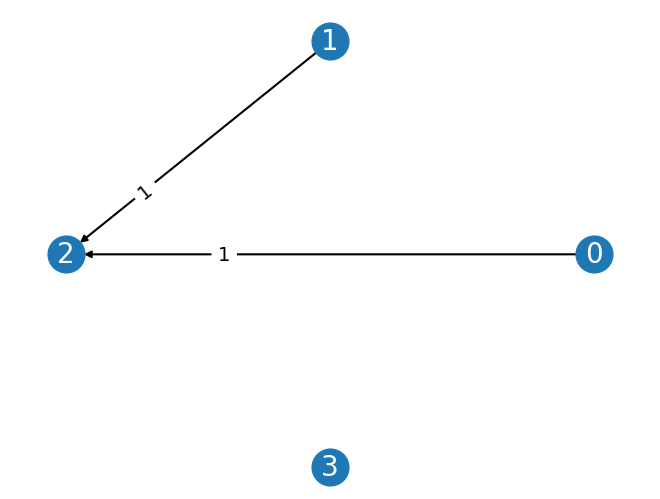

In [3]:
prof = ProfileWithTies([{0:1, 1:2, 2:3}, {0:2, 1:1},  {2:1}], candidates=[0, 1, 2, 3])

prof.display()
prof.display_support_graph()

sg = prof.support_graph()



In [3]:
prof = generate_truncated_profile(4, 55)
prof.display()
prof = generate_truncated_profile(4, 55, probmod="RT")
prof.display()


+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| 3 | 3 | 3 | 2 | 2 | 2 | 3 | 3 | 3 | 3 | 1 | 1 | 1 | 3 | 3 | 3 | 2 | 2 | 2 | 2 | 2 | 1 | 0 | 1 | 1 | 0 | 0 | 0 | 0 | 1 | 1 | 3 | 3 | 0 | 0 | 2 | 2 | 1 | 1 | 1 | 3 | 3 | 3 | 2 | 2 | 2 | 0 | 0 | 0 | 0 | 3 | 3 | 1 | 1 | 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 2 | 2 | 2 | 2 | 0 | 0 | 0 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 3 | 1 | 2 | 2 | 3 | 3 | 3 

In [4]:
for t in range(100): 
    num_cands = random.choice([1, 2, 3, 4, 5])
    num_voters = random.choice([1, 7, 10, 50, 1001])
    print(num_cands, num_voters)
    prof = generate_truncated_profile(num_cands, num_voters, probmod="IC")
    prof = generate_truncated_profile(num_cands, num_voters, probmod="RT")

3 10
2 10
2 50
5 7
1 10
4 1
1 50
5 1001
4 10
4 7
3 1001
1 7
2 10
4 1
3 7
1 1
4 1001
2 1
1 7
4 1001
4 1
4 1001
1 7
1 1
1 10
3 1001
2 7
1 1001
5 7
4 1
1 1001
5 10
1 1
4 7
2 1001
4 1
5 50
3 7
2 50
1 7
1 7
1 10
5 10
5 10
2 1001
1 1
2 7
1 7
5 1001
5 50
4 1001
2 10
5 1
4 1001
4 1
3 1
2 7
4 1001
1 50
2 1001
1 1
1 10
2 1
3 1
5 1001
3 10
2 10
2 10
5 7
2 7
5 7
1 7
1 50
1 1001
4 10
2 1001
1 1
2 50
3 7
2 10
1 1001
2 7
5 7
2 7
2 1
3 50
4 7
5 10
4 10
3 10
5 1001
1 1001
1 1001
3 10
2 7
3 10
1 50
5 1001
4 1
3 1001


In [7]:
prof = ProfileWithTies([{0:1, 1:2, 2:3}, {0:2, 1:1},  {2:1}], candidates=[0, 1, 2, 3])

prof.display()

for r in prof.rankings:
    print(r)
    print(r.to_linear())

print(prof.to_linear_profile())

prof = ProfileWithTies([{0:1, 1:2, 2:3}, {0:2, 1:1, 2:3},  {2:1, 3:2, 0:3}], candidates=[0, 1, 2, 3])

prof.display()

for r in prof.rankings:
    print(r)
    print(r.to_linear())

print(prof.to_linear_profile())

prof = ProfileWithTies([Ranking({0:1, 1:2, 2:3}), {0:2, 1:1, 2:3},  {1:1, 2:2, 0:3}])

prof.display()

for r in prof.rankings:
    print(r)
    print(r.to_linear())

print(prof.to_linear_profile())




+---+---+---+
| 1 | 1 | 1 |
+---+---+---+
| 0 | 1 | 2 |
| 1 | 0 |   |
| 2 |   |   |
|   |   |   |
+---+---+---+
0 1 2 
[0, 1, 2]
1 0 
[1, 0]
2 
[2]
Error: Cannot convert to linear profile.
None
+---+---+---+
| 1 | 1 | 1 |
+---+---+---+
| 0 | 1 | 2 |
| 1 | 0 | 3 |
| 2 | 2 | 0 |
|   |   |   |
+---+---+---+
0 1 2 
[0, 1, 2]
1 0 2 
[1, 0, 2]
2 3 0 
[2, 3, 0]
Error: Cannot convert to linear profile.
None
+---+---+---+
| 1 | 1 | 1 |
+---+---+---+
| 0 | 1 | 1 |
| 1 | 0 | 2 |
| 2 | 2 | 0 |
+---+---+---+
0 1 2 
[0, 1, 2]
1 0 2 
[1, 0, 2]
1 2 0 
[1, 2, 0]
+---+---+---+
| 1 | 1 | 1 |
+---+---+---+
| 0 | 1 | 1 |
| 1 | 0 | 2 |
| 2 | 2 | 0 |
+---+---+---+


In [8]:
get_cands = lambda r: list(r.keys()) if type(r) == dict else r.cands
rtest = [Ranking({0:1, 1:2, 2:3}), {0:2, 1:1, 2:3},  {1:1, 2:2, 3:3}]

for r in rtest:
    if type(r) == dict: 
        print(list(r.keys()))
    else:
        print(r.cands)

print([get_cands(r) for r in rtest])

[0, 1, 2]
[0, 1, 2]
[1, 2, 3]
[[0, 1, 2], [0, 1, 2], [1, 2, 3]]


In [9]:
prof.display()

n_prof = prof.add_unranked_candidates()

n_prof.display()

+---+---+---+
| 1 | 1 | 1 |
+---+---+---+
| 0 | 1 | 1 |
| 1 | 0 | 2 |
| 2 | 2 | 0 |
+---+---+---+
+---+---+---+
| 1 | 1 | 1 |
+---+---+---+
| 0 | 1 | 1 |
| 1 | 0 | 2 |
| 2 | 2 | 0 |
+---+---+---+


In [10]:
prof.plurality_scores(curr_cands = [0])

{0: 3}

In [11]:
plurality_with_runoff.display(prof)

PluralityWRunoff winner is {1}


In [12]:
plurality.display(prof)

Plurality winner is {1}


In [13]:
print(borda_for_profile_with_ties(prof, borda_scores=symmetric_borda_scores))
print(borda_for_profile_with_ties(prof, borda_scores=domination_borda_scores))
print(borda_for_profile_with_ties(prof, borda_scores=weak_domination_borda_scores))
print(borda_for_profile_with_ties(prof, borda_scores=non_domination_borda_scores))

[1]
[1]
[1]
[1]


In [16]:
for t in range(100): 
    prof = generate_profile(4, 11)  
    split_cycle.display(prof)   

Split Cycle winner is {0}
Split Cycle winner is {0}
Split Cycle winner is {0}
Split Cycle winner is {3}
Split Cycle winners are {0, 1}
Split Cycle winner is {0}
Split Cycle winners are {0, 1, 2}
Split Cycle winner is {2}
Split Cycle winner is {0}
Split Cycle winner is {2}
Split Cycle winner is {3}
Split Cycle winner is {3}
Split Cycle winner is {3}
Split Cycle winners are {0, 1, 3}
Split Cycle winner is {3}
Split Cycle winner is {1}
Split Cycle winner is {1}
Split Cycle winner is {3}
Split Cycle winner is {0}
Split Cycle winner is {3}
Split Cycle winner is {2}
Split Cycle winner is {1}
Split Cycle winner is {2}
Split Cycle winner is {0}
Split Cycle winner is {3}
Split Cycle winner is {0}
Split Cycle winner is {0}
Split Cycle winner is {1}
Split Cycle winner is {3}
Split Cycle winner is {1}
Split Cycle winners are {0, 2}
Split Cycle winner is {3}
Split Cycle winner is {0}
Split Cycle winner is {2}
Split Cycle winner is {3}
Split Cycle winner is {1}
Split Cycle winner is {2}
Split Cycle 

In [18]:

for t in range(100):
    for vm in [split_cycle, 
               stable_voting, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               simple_stable_voting, 
               copeland,
               borda, 
               plurality, 
               plurality_with_runoff, 
               instant_runoff, 
               coombs, 
               minimax, 
               strict_nanson, 
               bucklin]: 

        prof = generate_profile(5, 11)

        vm.display(prof)
        
        prof = generate_profile(5, 10)

        vm.display(prof)


    print()




Split Cycle winner is {2}
Split Cycle winner is {2}
Stable Voting winner is {3}
Stable Voting winner is {1}
Beat Path winners are {0, 3, 4}
Beat Path winner is {1}
Beat Path winner is {1}
Beat Path winner is {2}
Split Cycle winners are {0, 1, 3, 4}
Split Cycle winners are {1, 2, 3}
Simple Stable Voting winner is {4}
Simple Stable Voting winner is {3}
Borda winner is {4}
Borda winner is {0}
Plurality winner is {2}
Plurality winners are {0, 2, 3}
PluralityWRunoff winner is {0}
PluralityWRunoff winner is {1}
Instant Runoff winner is {1}
Instant Runoff winner is {4}
Coombs winner is {2}
Coombs winner is {4}
Minimax winner is {3}
Minimax winners are {2, 3}
Strict Nanson winner is {4}
Strict Nanson winner is {3}
Bucklin winner is {3}
Bucklin winners are {2, 3, 4}

Split Cycle winner is {3}
Split Cycle winner is {4}
Stable Voting winner is {3}
Stable Voting winner is {1}
Beat Path winner is {3}
Beat Path winner is {3}
Beat Path winners are {0, 2}
Beat Path winners are {0, 1, 3}
Split Cycle wi

In [20]:
for t in range(100):
    for vm in [split_cycle, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               plurality,
               stable_voting, 
               simple_stable_voting, 
               copeland,
               borda_for_profile_with_ties,
               instant_runoff_for_truncated_linear_orders
               ]: 

        prof = generate_truncated_profile(5, 11)

        vm.display(prof)
        prof = generate_truncated_profile(5, 10)

        vm.display(prof)

    print()


Split Cycle winners are {1, 3}
Split Cycle winners are {2, 4}
Beat Path winner is {1}
Beat Path winners are {0, 2}
Beat Path winners are {1, 3}
Beat Path winners are {1, 2}
Split Cycle winner is {4}
Split Cycle winners are {2, 3}
Plurality winner is {0}
Plurality winner is {0}
Stable Voting winners are {3, 4}
Stable Voting winners are {1, 3}
Simple Stable Voting winners are {1, 2, 3, 4}
Simple Stable Voting winner is {2}
Borda winner is {1}
Borda winner is {3}
Instant Runoff winner is {2}
Instant Runoff winner is {2}

Split Cycle winners are {1, 2}
Split Cycle winners are {0, 3, 4}
Beat Path winner is {4}
Beat Path winners are {1, 2, 3}
Beat Path winners are {2, 3}
Beat Path winners are {1, 2}
Split Cycle winners are {0, 3}
Split Cycle winners are {0, 1, 3}
Plurality winners are {0, 3}
Plurality winner is {0}
Stable Voting winner is {0}
Stable Voting winner is {1}
Simple Stable Voting winner is {4}
Simple Stable Voting winner is {3}
Borda winner is {1}
Borda winner is {1}
Instant Runof

In [23]:
for t in range(100):
    for vm in [split_cycle, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               stable_voting, 
               simple_stable_voting, 
               gocha,
               smith_set,
               copeland
               ]: 

        mg = generate_margin_graph(5)

        vm.display(mg)
        mg = generate_edge_ordered_tournament(4)
        vm.display(mg)

        mg = generate_edge_ordered_tournament_infinite_limit(5)
        vm.display(mg)



    print()


Split Cycle winner is {4}
Split Cycle winner is {1}
Split Cycle winner is {0}
Beat Path winners are {3, 4}
Beat Path winner is {3}
Beat Path winner is {3}
Beat Path winners are {0, 4}
Beat Path winner is {3}
Beat Path winner is {4}
Split Cycle winner is {2}
Split Cycle winner is {3}
Split Cycle winner is {0}
Stable Voting winner is {3}
Stable Voting winner is {0}
Stable Voting winner is {4}
Simple Stable Voting winner is {4}
Simple Stable Voting winner is {0}
Simple Stable Voting winner is {0}
GOCHA winners are {0, 1, 2, 3, 4}
GOCHA winner is {3}
GOCHA winner is {2}
Smith Set winners are {0, 1, 2, 3, 4}
Smith Set winners are {1, 2, 3}
Smith Set winners are {0, 1, 2, 3, 4}
Copeland winners are {1, 3}
Copeland winner is {0}
Copeland winners are {1, 4}

Split Cycle winner is {4}
Split Cycle winner is {3}
Split Cycle winner is {2}
Beat Path winner is {1}
Beat Path winner is {0}
Beat Path winner is {3}
Beat Path winner is {3}
Beat Path winner is {2}
Beat Path winner is {4}
Split Cycle winne